## 先上一下最终效果图吧

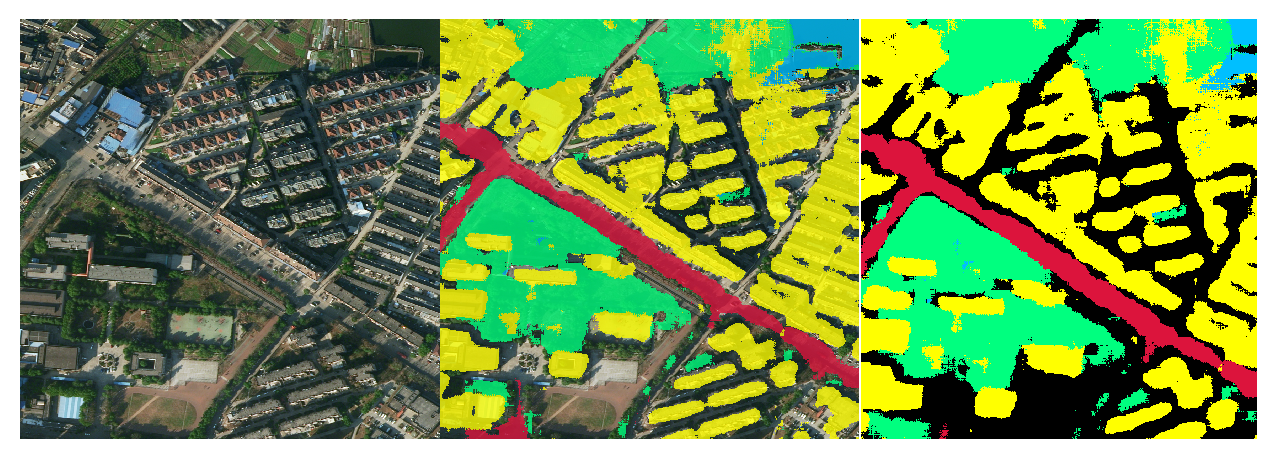

### 0.------------------------------VGG预训练网络的各层结构------------------------------

In [7]:
from torchvision import models

pretrained_net = models.vgg16_bn(pretrained=False)
pretrained_net.features[:7]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

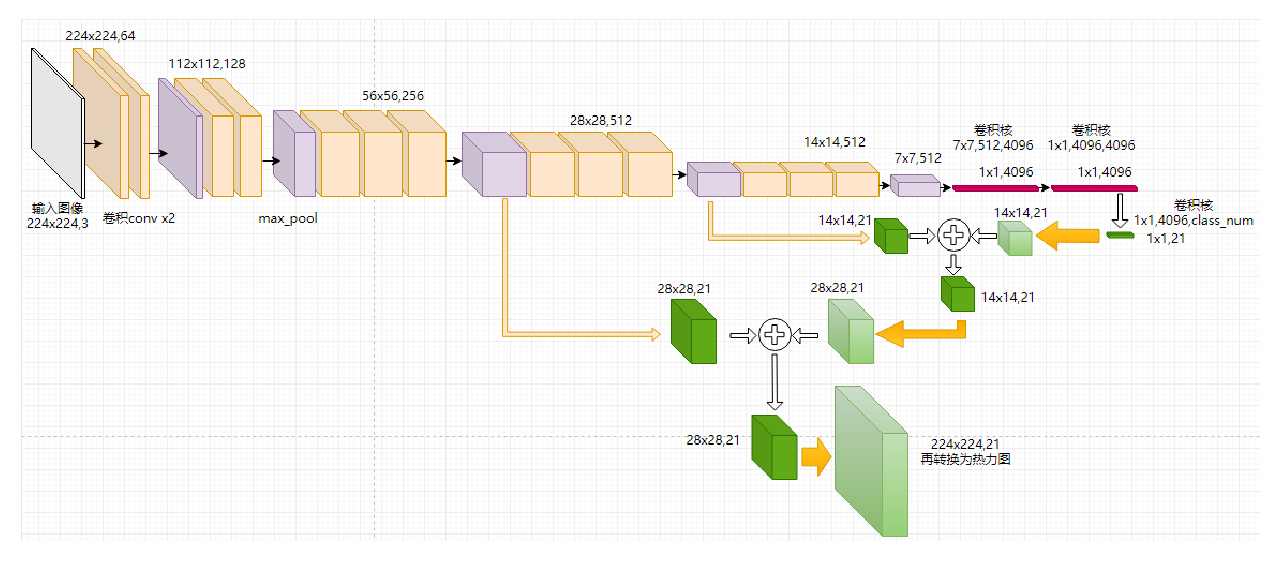

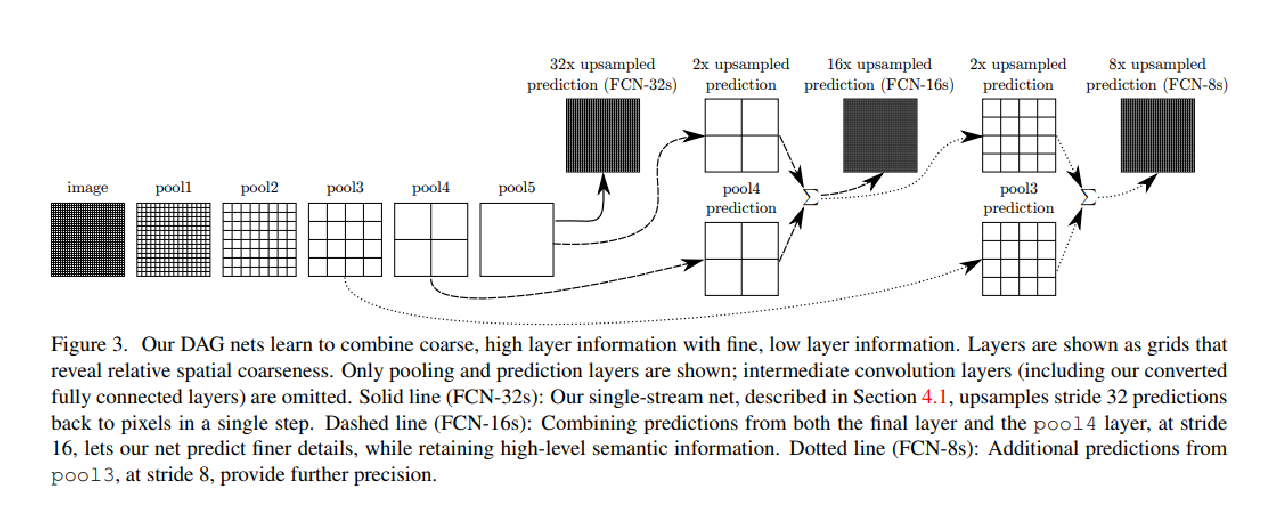

### 1.------------------------------FCN8s 网络结构代码实现------------------------------

In [1]:
import torch.nn as nn
from torchvision import models
import numpy as np
import torch

class FCN8s(nn.Module):
        # 定义双线性插值，作为转置卷积的初始化权重参数
    def __init__(self,pretrained_net,num_classes):
        super(FCN8s,self).__init__()
        
        # (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        # (2): ReLU(inplace=True)
        # (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        # (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        # (5): ReLU(inplace=True)
        # (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # pool1 按照上述图片命名
        self.pool1 = pretrained_net.features[:7]
        self.pool2 = pretrained_net.features[7:14]
        self.pool3 = pretrained_net.features[14:24]
        self.pool4 = pretrained_net.features[24:34]
        self.pool5 = pretrained_net.features[34:]
        
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)
        
        
    def forward(self,x):     # x = 352, 480，3 = height, width, channels
        
        # s1第一个下采样块的输出特征图
        # x为输入图像
        # layer1 为Vgg网络下，第一个下采样块和之前的结构
        s1 = self.pool1(x)  #  >>> s1 = 176, 240，64 # 1/2
        s2 = self.pool2(s1) #  >>> s2 = 88, 120, 128 # 1/4
        s3 = self.pool3(s2) #  >>> s3 = 44, 60, 256  # 1/8
        s4 = self.pool4(s3) #  >>> s4 = 22, 30, 512  # 1/16
        s5 = self.pool5(s4) #  >>> s5 = 11, 15, 512  # 1/32 通道数增加到512，到700左右就行了，不闭增加过多
        
        # relu 用来防止梯度消失
        # bn 层用来，使数据保持高斯分布
        # bn层 的里面是relu层，外面是转置卷积层， relu内部接转置卷积结果
        scores = self.relu(self.deconv1(s5))                  # h,w,n = 22, 30, 512   1/16
        scores = self.bn1(scores + s4)                        # h,w,n = 22, 30, 512   1/16
        
        scores = self.relu(self.deconv2(scores))              # h,w,n = 44 , 60, 256   1/8
        scores = self.bn2(scores + s3)
        
        scores = self.bn3(self.relu(self.deconv3(scores)))    # h,w,n = 88, 120, 128   1/4
        
        scores = self.bn4(self.relu(self.deconv4(scores)))    # h,w,n = 176, 240, 64   1/2
        
        scores = self.bn5(self.relu(self.deconv5(scores)))   # h,w,n = 352, 480, 32    1/1
        
        return self.classifier(scores) # h,w,n= 352, 480, 5  1/1
        
if __name__ == '__main__':
    
    import torch as t
    import torch.nn.functional as F
    
    # 输入图像特征为 1张图片，3通道，尺寸为 h,w = 352,480
    rgb = t.randn(1, 3, 352, 352)

    pretrained_net = models.vgg16_bn(pretrained=False)
    net = FCN8s(pretrained_net , 5)

    # 经过网络传播
    out = net(rgb)
    
    out = F.log_softmax(out,dim = 1)
    
    print(out)
    print(out.shape) #  经过网络传播最后为 [1, 5, 352, 480]，即1张预测图，5个通道，h,w = 352,480 

tensor([[[[-1.5827, -1.8895, -1.7572,  ..., -1.9058, -1.8839, -1.6713],
          [-1.9084, -1.8617, -1.6144,  ..., -2.3926, -1.5768, -1.3710],
          [-1.8460, -1.3676, -1.7252,  ..., -1.5843, -1.3668, -2.0050],
          ...,
          [-2.0610, -2.1815, -1.8912,  ..., -2.0605, -1.9788, -2.0941],
          [-1.7240, -2.2641, -1.6611,  ..., -2.0093, -1.7397, -1.6808],
          [-2.1793, -1.2664, -1.5017,  ..., -2.0123, -1.9199, -1.5142]],

         [[-2.1263, -1.5411, -1.9212,  ..., -1.3340, -1.7481, -2.2848],
          [-1.6721, -2.1078, -2.1640,  ..., -1.7890, -1.3155, -2.7295],
          [-1.8849, -1.7432, -2.4822,  ..., -2.6624, -2.3944, -1.0921],
          ...,
          [-1.2109, -1.1526, -1.1658,  ..., -2.1488, -1.5376, -1.3443],
          [-1.9042, -1.4888, -1.6515,  ..., -2.1279, -1.9593, -1.7722],
          [-1.6680, -1.7149, -2.4096,  ..., -1.3255, -1.6041, -1.9842]],

         [[-1.2739, -1.4059, -1.4801,  ..., -1.8587, -1.4247, -1.5167],
          [-1.4086, -1.5008, -

## 2.------------------------------数据集导入------------------------------

In [49]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import torch as t
import os
import numpy as numpy

class LabelUtil:
    # Introduction 
    # 这个类的功能:
    #    Convert a tag image with 3 channels to a tag image with 1 channel.
    #    Each pixel value of the 1-channel image is an integer, each integer representing the corresponding RGB value in the original 3-channel tag, as well as a category
    #    将一张 彩色 Label 转换成 一个单通道的  图片数组，
    #    每个颜色用一个 整数代表，一个整数代表一个类别
    # Example:
    # ---------
    #  (0,0,0) ==> Background->(0), (0,255,127)==>Vegetation->(1), (220,20,60)==>Roads->(2),(255,255,0)==>Building->(3), (0,191,255)==> River->(4)
    #  color = [(0,0,0),(0,255,127),(220,20,60),(255,255,0),(0,191,255)]
    def __init__(self, color):
        # 创建一个Hash数组, 每一种颜色，给定一个下标值，这个下标所在的位置的值 是一个整数id，一个id，代表一个分类
        cm = np.zeros(256**3)
        for cid,item in enumerate(color):
            cm[ (item[0]*256 + item[1])*256 + item[2] ] = cid
        self.colormap = cm
        
    def __call__(self, pic):
        # three channels to one channels
        # RGB ---> I
        # 其中：
        #    RGB  ---> K --> I,  K = ( R * 256 + G) * 256 + B ----> 每个颜色有个 id， 参见 代码第18行。
        label = np.array(pic,dtype = 'uint32')
        cid = (label[:,:,0]*256 + label[:,:,1])*256 + label[:,:,2]
        #         Example:
        #         -------
        #           cid = ⇩                                                   return  
        #             [[       0        0        0        0        0]         [[0 0 0 0 0]
        #              [       0    65407        0        0        0]          [0 1 0 0 0]
        #              [       0        0 14423100        0        0]   ===>   [0 0 2 0 0]
        #              [       0        0        0 16776960        0]          [0 0 0 3 0] 
        #              [       0        0        0        0    49151]]         [0 0 0 0 4]]    
        return np.array(self.colormap[ cid ], dtype = 'uint8')
      
        
class UserDataset(Dataset):
    
    def __init__(self, img_path : str, label_path : str, labelUtils : LabelUtil):
        super(UserDataset,self).__init__()
        # 初始化图片和标签全路径，数组
        self.imgslist = [os.path.join(img_path,item) for item in os.listdir(img_path)]
        self.labelslist = [os.path.join(label_path,item) for item in os.listdir(label_path)]
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.labelUtils = labelUtils
        # 路径按名字，排个序
        self.imgslist.sort()
        self.labelslist.sort()
        
    def __getitem__(self,index):
        
        # open image with PIL
        img, label = Image.open( self.imgslist[index] ),Image.open( self.labelslist[index] )
        # 注意：
        #      label 和 image 如果尺寸相同，可往下走。若不同需要另外书写代码，用中心裁剪，变成尺寸相同的。
        #      如果label是单通道，可替换下面的RGB_Label_To_SingleChannel_To_Tensor 变为 t.from_numpy(label)
        #      下面处理的label 是3通道的彩色图
        labelx = Image.new('RGB',label.size)
        labelx.paste(label,(0,0))
        
        img, label = self.transforms(img),t.from_numpy(self.labelUtils(label))
        
        sample = {'img':img, 'label':label}
        
        return sample
    
    def __len__(self):
        return len(self.imgslist)

# 创建数据集
#  1.初始化路径，以及标签
train_root_path = r'E:\dataset\BDCI2017-jiage-Semi\training\train'
label_root_path = r'E:\dataset\BDCI2017-jiage-Semi\training\train_labels'
color = [[0,0,0],[0,255,127],[255,255,0],[0,191,255],[220,20,60]]
# 2.
labelUtils = LabelUtil(color)
userDataset = UserDataset(train_root_path, label_root_path, labelUtils )
userDataset[0]['img'].shape
            # # Valid
            # sample = userDataset[3]
            # #sample['img'].max(1)[0]
            # label = sample['label']
            # labelx = sample['lx']
            # print('label.shape = ',label.shape)

            # import random
            # def printcoordinate(label3,label):
            #     for i in range(20):
            #         coordinates = (random.randint(0,label3.size[0]-1),random.randint(0,label3.size[1]-1))
            #         print('label x,y = ',coordinates,' pixel', label3.getpixel(coordinates),'tensor = ',label[coordinates[1],coordinates[0]])

            # printcoordinate(labelx,label)
            # # cm2lbl[index]  index =  0   cm =   [0, 0, 0]  i = 0              Background   
            # # cm2lbl[index]  index =  65407   cm =   [0, 255, 127]  i = 1      Vegetation
            # # cm2lbl[index]  index =  16776960   cm =   [255, 255, 0]  i = 2   Building
            # # cm2lbl[index]  index =  49151   cm =   [0, 191, 255]  i = 3      River    
            # # cm2lbl[index]  index =  14423100   cm =   [220, 20, 60]  i = 4   Roads

# 检查原来数据集输出label的尺寸以及大小，内部值
# 不做改变后

torch.Size([3, 352, 352])

## 3.------------------------------训练------------------------------

In [3]:
from torch.utils.data import DataLoader
import torch
from torch import optim
from torch.autograd import Variable 
import torch.nn as nn
from tqdm import tqdm
import torch as t
import logging as log


class TrainUtils:
    
    def __init__(self, userDataset : UserDataset, batchSize : int, fcn : FCN8s, modelSavePath : str):
        
        self.dataLoader = DataLoader(userDataset, batch_size=batchSize,num_workers = 0)
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.fcn = fcn.to(self.device)
        self.optimizer = optim.Adam(fcn.parameters(), lr = 1e-4)
        self.calLoss = nn.CrossEntropyLoss().to(self.device) # .to(self.device) <====> .cuda()
        
        self.loss = 0
        self.modelsavepath = modelSavePath
        
    def trainNet(self):
        for epoch in range(30):
            print('epoch = '+str(epoch)+',  loss = '+str(self.loss))
            
            if epoch % 10 == 0 and epoch != 0:
                for group in self.optimizer.param_groups:
                    group['lr'] *= 0.5
            
            self.fcn.train() # 设置为训练过程。此时网络 的 参数能够进行参数学习
            for i, sample in tqdm(enumerate(self.dataLoader)):
                #  Variable为tensor数据构建计算图，便于网络的运算 https://www.cnblogs.com/czz0508/p/10333359.html
                imgdata, imglabel = Variable(sample['img']).to(self.device), Variable(sample['label'].long()).to(self.device)

                self.optimizer.zero_grad() # 梯度清0

                netOutput = self.fcn(imgdata) # 将训练图片 送入网络

                loss = self.calLoss(netOutput , imglabel) # 计算损失, label 和 网络输出的预测的结果进行对比，计算loss

                loss.backward() # 误差反向传播

                self.optimizer.step() # 用优化器去更新权重参数

                self.loss += loss.item() # 训练损失 记录
            
        t.save(self.fcn.state_dict(), self.modelsavepath)
        print('*'*10,'train  end')
            
            
# userDataset 为上一个部分，得到的数据集对象  

pretrained_net = models.vgg16_bn(pretrained=False)

batchSize = 4
net = FCN8s(pretrained_net , 5)
modelSavePath = './fcn8snew.pth'

trainUtils = TrainUtils(userDataset, batchSize, net, modelSavePath)
trainUtils.trainNet()

0it [00:00, ?it/s]

epoch = 0,  loss = 0


1422it [14:37,  1.62it/s]
0it [00:00, ?it/s]

epoch = 1,  loss = 1881.4240400791168


1422it [14:32,  1.63it/s]
0it [00:00, ?it/s]

epoch = 2,  loss = 3539.5469628572464


1422it [14:15,  1.66it/s]
0it [00:00, ?it/s]

epoch = 3,  loss = 5059.516435712576


1422it [14:18,  1.66it/s]
0it [00:00, ?it/s]

epoch = 4,  loss = 6495.223480761051


1422it [14:19,  1.65it/s]
0it [00:00, ?it/s]

epoch = 5,  loss = 7864.146918803453


1422it [14:20,  1.65it/s]
0it [00:00, ?it/s]

epoch = 6,  loss = 9182.879330396652


1422it [14:26,  1.64it/s]
0it [00:00, ?it/s]

epoch = 7,  loss = 10459.654334783554


1422it [14:20,  1.65it/s]
0it [00:00, ?it/s]

epoch = 8,  loss = 11699.694204390049


1422it [14:16,  1.66it/s]
0it [00:00, ?it/s]

epoch = 9,  loss = 12907.97522443533


1422it [14:15,  1.66it/s]
0it [00:00, ?it/s]

epoch = 10,  loss = 14085.144336014986


1422it [14:21,  1.65it/s]
0it [00:00, ?it/s]

epoch = 11,  loss = 15207.924770921469


1422it [14:21,  1.65it/s]
0it [00:00, ?it/s]

epoch = 12,  loss = 16295.666581392288


1422it [14:14,  1.66it/s]
0it [00:00, ?it/s]

epoch = 13,  loss = 17356.76225399971


1422it [14:13,  1.67it/s]
0it [00:00, ?it/s]

epoch = 14,  loss = 18392.923839330673


1422it [14:13,  1.67it/s]
0it [00:00, ?it/s]

epoch = 15,  loss = 19404.73461896181


1422it [14:16,  1.66it/s]
0it [00:00, ?it/s]

epoch = 16,  loss = 20392.57490774989


1422it [14:23,  1.65it/s]
0it [00:00, ?it/s]

epoch = 17,  loss = 21356.494061887264


1422it [14:20,  1.65it/s]
0it [00:00, ?it/s]

epoch = 18,  loss = 22296.535532206297


1422it [14:14,  1.66it/s]
0it [00:00, ?it/s]

epoch = 19,  loss = 23212.51785260439


1422it [14:13,  1.67it/s]
0it [00:00, ?it/s]

epoch = 20,  loss = 24104.336699083447


1422it [14:13,  1.67it/s]
0it [00:00, ?it/s]

epoch = 21,  loss = 24967.66241583228


1422it [14:26,  1.64it/s]
0it [00:00, ?it/s]

epoch = 22,  loss = 25808.347037017345


1422it [14:18,  1.66it/s]
0it [00:00, ?it/s]

epoch = 23,  loss = 26629.72164040804


1422it [14:16,  1.66it/s]
0it [00:00, ?it/s]

epoch = 24,  loss = 27432.738452851772


1422it [14:31,  1.63it/s]
0it [00:00, ?it/s]

epoch = 25,  loss = 28217.984437927604


1422it [14:30,  1.63it/s]
0it [00:00, ?it/s]

epoch = 26,  loss = 28985.7816131711


1422it [14:19,  1.65it/s]
0it [00:00, ?it/s]

epoch = 27,  loss = 29736.175394803286


1422it [14:16,  1.66it/s]
0it [00:00, ?it/s]

epoch = 28,  loss = 30469.21356767416


1422it [14:22,  1.65it/s]
0it [00:00, ?it/s]

epoch = 29,  loss = 31184.994791030884


1422it [14:23,  1.65it/s]


********** train  end


## 4.------------------------------------ 预测单张图片----------------------------------------

In [31]:
import torch 
import torch as t
import torch.nn.functional as F
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import cv2
from time import time

class PredictUtil:
    
    def __init__(self, modelSavePath : str, net :FCN8s, colormap):
        net.load_state_dict(t.load(modelSavePath))
        net.eval()
        self.net = net #.cuda()
        self.colorMap = np.array(colormap).astype('uint8')
        self.ImageTransToTensor = transforms.Compose([transforms.ToTensor(),
                                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
    def __call__(self,predictImagePath : str, resultImageSavePath : str):
        print( '*' * 10,'begin predict')
        preImage = Image.open(predictImagePath)
        preImage = self.ImageTransToTensor(preImage)# .cuda()  # torch.Size([3, 352, 352])
        preImage = torch.unsqueeze(preImage, dim=0)# .cuda()  # torch.Size([1, 3, 352, 352])
        
        netOutScoresImage = self.net(preImage) #.cuda()
        
        netOutRateImage = F.log_softmax(netOutScoresImage, dim = 1)
        
        predicMatrix = netOutRateImage.max(1)[1].squeeze().cpu().data.numpy()
        resultPicArray = self.colorMap[predicMatrix]
        
        resultImage = Image.fromarray(resultPicArray).convert('RGBA')
        
        resultImage.save(resultImageSavePath)
        resultImage.show()
        

from IPython.display import clear_output as clear
clear()
from PIL.Image import NEAREST, BILINEAR, BICUBIC, LANCZOS, BOX, HAMMING

# begin train

# 预训练对象
pretrained_net = models.vgg16_bn(pretrained=False)
# 模型保存路径
modelSavePath = './fcn8snew.pth'
# 创建网络对象
net = FCN8s(pretrained_net , 5)
# 可视化结果的Map
# 下面是 RGBA 的值
colormap = [[0,0,0,0],[0,255,127,200],[255,255,0,200],[0,191,255,200],[220,20,60,200]]

n = 50
# 3536,6116

img = cv2.imread(r'E:/dataset/BDCI2017-jiage-Semi/testing/testing3.png')
img = img[0:32*n,0:32*n]
cv2.imwrite(r'E:/dataset/BDCI2017-jiage-Semi/testing/testing3x-'+str(n)+'.png',img)

# 预测图片的路径
predictImagePath =  r'E:/dataset/BDCI2017-jiage-Semi/testing/testing3x-'+str(n)+'.png'
# 结果保存的路径以及名称
predictResultSavePath = r'E:/dataset/BDCI2017-jiage-Semi/testing/testing3x-'+str(n)+'x.png'

print(n*32)
print(predictImagePath,predictResultSavePath)

# begin to predict
predictUtil = PredictUtil(modelSavePath, net, colormap)
predictUtil(predictImagePath, predictResultSavePath)


1600
E:/dataset/BDCI2017-jiage-Semi/testing/testing3x-50.png E:/dataset/BDCI2017-jiage-Semi/testing/testing3x-50x.png
********** begin predict


### 让预测图片成为原图的mask，覆盖其上

In [46]:
# 覆盖
img1 = cv2.imread(predictImagePath, -1)
img2 = cv2.imread(predictResultSavePath, -1) # this one has transparency
h, w, c = img2.shape

img1 = cv2.resize(img1, (w, h), interpolation = cv2.INTER_CUBIC)
result = np.zeros((h, w, 3), np.uint8)

#fast
st = time()
alpha = img2[:, :, 3] / 255.0
result[:, :, 0] = (1. - alpha) * img1[:, :, 0] + alpha * img2[:, :, 0]
result[:, :, 1] = (1. - alpha) * img1[:, :, 1] + alpha * img2[:, :, 1]
result[:, :, 2] = (1. - alpha) * img1[:, :, 2] + alpha * img2[:, :, 2]
end = time() - st

path3 = './combine.png'

cv2.imwrite(path3 , result)

16.571996212005615


True

### 将上述处理得到的图片和原图放在一起左右排列

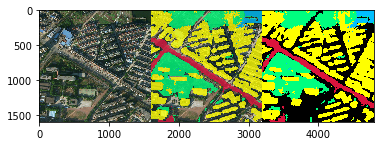

In [7]:
# cat
from PIL import Image
import matplotlib.pyplot as plt

predictImagePath = r'E:/dataset/BDCI2017-jiage-Semi/testing/testing3x-50.png'
predictResultSavePath = r'E:/dataset/BDCI2017-jiage-Semi/testing/testing3x-50x.png'

a,b,c = Image.open(predictImagePath),Image.open('./combine.png'),Image.open(predictResultSavePath)
d = Image.new('RGB',(a.size[0]*3,a.size[1]))
d.paste(a,(0,0))
d.paste(b,(a.size[0],0))
d.paste(c,(a.size[0]+b.size[0],0))

plt.imshow(d)

### 彩色3通道图片变为单 通道图片
### 每个颜色，对应单通道图片中  一个唯一整数

In [22]:

# ↑↓←→
colormap = [[0, 0, 0], [0, 255, 127], [220, 20, 60], [255, 255, 0], [0, 191, 255]]


temp = np.zeros(256**3)
for i,cm in enumerate(colormap):
    mapx = (cm[0] * 256 + cm[1]) * 256 + cm[2]
    temp[ mapx ] = i

# init pic
img = np.zeros((5,5,3),dtype = np.int32)
for i in range(0,5):
    for j in range(0,5):
        if i==j :
            img[i,j] = colormap[j]

print('\n channel R = ↓ \n')
print(img[:,:,0])
print('\n channel G = ↓ \n')
print(img[:,:,1])
print('\n channel B = ↓ \n')
print(img[:,:,2])

idx = (img[:,:,0]*256 + img[:,:,1])*256 + img[:,:,2]

print('\n 3 channels to 1 channels = ↓ \n')
print(idx)

label = np.array(temp[ idx ],dtype = np.int64)

print('\n our result = ↓ \n')
print( label )


 channel R = ↓ 

[[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0 220   0   0]
 [  0   0   0 255   0]
 [  0   0   0   0   0]]

 channel G = ↓ 

[[  0   0   0   0   0]
 [  0 255   0   0   0]
 [  0   0  20   0   0]
 [  0   0   0 255   0]
 [  0   0   0   0 191]]

 channel B = ↓ 

[[  0   0   0   0   0]
 [  0 127   0   0   0]
 [  0   0  60   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0 255]]

 3 channels to 1 channels = ↓ 

[[       0        0        0        0        0]
 [       0    65407        0        0        0]
 [       0        0 14423100        0        0]
 [       0        0        0 16776960        0]
 [       0        0        0        0    49151]]

 our result = ↓ 

[[0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 2 0 0]
 [0 0 0 3 0]
 [0 0 0 0 4]]
